<a href="https://colab.research.google.com/github/paoandreachv/Practica/blob/Prueba/Mina_Los_Bronces%2C_Colina.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PyGMTSAR Tailings Dam Interferogram: Los Bronces Mine, Colina, Chile.

blablabla

# Instalación de Google Colab

Instalaremos PyGMTSAR y los binarios requeridos de GMTSAR para que este software funcione (incluyendo SNAPHU, el cual es una herramienta complementaria usada específicamente para desenvolver fases interferométricas en imágenes de radar).


Este código se encarga de instalar las librerías y herramientas necesarias para el procesamiento InSAR en Google Colab, configurar el entorno para la visualización interactiva, y verificar que todo esté correctamente instalado.

In [174]:
# Importaremos las librerías necesarias y se verifica si el código se está
# ejecutando en Google Colab.

import platform, sys, os

if 'google.colab' in sys.modules:
# Instalación de la librería PyGMTSAR
  !{sys.executable} -m pip install -q pygmtsar
  # Instalación de dependencias binarias
  import importlib.resources as resources
  with resources.as_file(resources.files('pygmtsar.data') / 'google_colab.sh') as google_colab_script_filename:
      !sh {google_colab_script_filename}
  # Vamos a permitir la visualización interactiva de datos
  from google.colab import output
  output.enable_custom_widget_manager()
  # Se inicializa un espacio de memoria (buffer) que simula una pantalla, permitiendo realizar operaciones gráficas 3D
  import xvfbwrapper
  display = xvfbwrapper.Xvfb(width=800, height=600)
  display.start()

# Configuramos la variable de entorno PATH para que incluya la ruta de instalación de GMTSAR
PATH = os.environ['PATH']
if PATH.find('GMTSAR') == -1:
    PATH = os.environ['PATH'] + ':/usr/local/GMTSAR/bin/'
    %env PATH {PATH}

# Se imprime la versión de PyGMTSAR que se ha instalado.
from pygmtsar import __version__
__version__


'2024.8.30.post5'

# Cargar y configurar módulos de Python

In [175]:
# Se utiliza para trabajar con datos multidimensionales, como los datos de SAR.
import xarray as xr

# Permite trabajar con matrices y operaciones numéricas.
import numpy as np

# Se utiliza para manipular y analizar datos tabulares.
import pandas as pd

# Se utiliza para trabajar datos geoespaciales.
import geopandas as gpd

# Se usa comúnmente para almacenar y transferir datos.
import json

# Dask es ideal para trabajos que no caben en la memoria de un solo equipo.
from dask.distributed import Client

# Procesa grandes conjuntos de datos
import dask

Esta parte del código se encarga de importar y configurar las librerías necesarias para la visualización de los datos. Se divide en dos partes importantes:

- Módulos de gráficos


In [176]:
# Módulos de gráficos

# Importa la librería de PyVista (pv), que se usa para la
# visualización 3D interactiva.
import pyvista as pv

# Configura el tema de PyVista a "document", que generalmente
# usa un fondo blanco para las gráficas.
pv.set_plot_theme("document")

# Importa la librería Panel, que se usa para crear paneles interactivos
# y visualizaciones web.
import panel

# Habilita la comunicación entre Panel y los widgets de Jupyter.
panel.extension(comms='ipywidgets')

# Habilita el soporte para visualizaciones VTK (Visualization Toolkit)
# en Panel, lo que permite integrar PyVista.
panel.extension('vtk')

# Importa contextmanager para manejar el contexto de la configuración de Matplotlib
from contextlib import contextmanager

# Importa la librería Matplotlib (plt), que se usa para crear gráficos estáticos.

import matplotlib.pyplot as plt

## Se define una función mpl_setting y configura los parámetros de Matplotlib


# Con esto se define el administrador de contexto, el cual controla lo que ocurre
# antes y después de ejecutar un bloque de código.
@contextmanager

# La función mpl_settings es un administrador de contexto, es decir, es una funcionalidad
# que permite ejecutar un bloque de código dentro de un entorno controlado. Este entorno
# generalmente asegura que se realicen ciertas acciones antes y después de ejecutar ese bloque
# de código, como configurar algo temporalmente y luego restaurarlo al finalizar. Lo que
# generará este administrador de contexto es que permitirá cambiar temporalmente la configuración
# de Matplotlib y luego restaurarla a su estado original.

def mpl_settings(settings):
    original_settings = {k: plt.rcParams[k] for k in settings}
    plt.rcParams.update(settings)
    yield
    plt.rcParams.update(original_settings)

plt.rcParams['figure.figsize'] = [12, 4]
plt.rcParams['figure.dpi'] = 100
plt.rcParams['figure.titlesize'] = 24
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
%matplotlib inline

In [177]:
# Configura las opciones de visualización de Pandas
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', 100)

In [178]:
# Se importan varias clases y funciones de la librería PyGMTSAR, que se usa para el
# procesamiento de datos de interferomoetría de radar de apertura sintética (InSAR).

from pygmtsar import S1, Stack, tqdm_dask, ASF, Tiles

## Escenas SLC de Sentinel-1 y parámetros de procesamiento


### Descending Orbit Configuration

In [179]:
SCENES = ['S1A_IW_SLC__1SDV_20230526T100433_20230526T100500_048703_05DB82_E456',
          'S1A_IW_SLC__1SDV_20240601T100437_20240601T100504_054128_069509_FD9C',
          'S1A_IW_SLC__1SDV_20250103T100432_20250103T100458_057278_070BF6_DDD6']
ORBIT        = 'D'
SUBSWATH     = 1

In [180]:
import os

# Directorios definidos
WORKDIR = '/content/directorios_slc/raw_minalosbronces'
DATADIR = '/content/directorios_slc/data_minalosbronces'

# Crear los directorios si no existen
os.makedirs(WORKDIR, exist_ok=True)
os.makedirs(DATADIR, exist_ok=True)

print(f"Directorios preparados:\n- {WORKDIR}\n- {DATADIR}")
POLARIZATION = 'VV'

Directorios preparados:
- /content/directorios_slc/raw_minalosbronces
- /content/directorios_slc/data_minalosbronces


In [173]:
#import shutil

# Ruta de la carpeta que deseas eliminar
#folder_path = "/content/directorios_slc/raw_minalosbronces"

# Eliminar la carpeta y su contenido
#shutil.rmtree(folder_path, ignore_errors=True)

In [181]:

DEM = f'{DATADIR}/demTranque.nc'

print(DEM)

/content/directorios_slc/data_minalosbronces/demTranque.nc


In [182]:
# Define una cadena de texto en formato Geo JSON que describe un área
# de interés (AOI). En este caso, el AOI se define como una línea que
# conecta dos puntos geográficos.

geojson = '''

{
  "type": "Feature",
  "geometry": {
    "type": "Polygon",
    "coordinates": [[[-70.55, -33.29], [-70.83, -33.24], [-70.80, -33.07], [-70.51, -33.12]]]
  },
  "properties": {}
}
'''

AOI = gpd.GeoDataFrame.from_features([json.loads(geojson)])

# Descargar y descomprimir conjuntos de datos

En esta sección nos encargaremos de obtener las imágenes Sentinel-1 necesarias para el análisis InSAR

In [183]:
# Ingresamos datos de cuenta en Alaska Satellite Facility (ASF)

asf_username = 'paao.ndra_2024'
asf_password = '@Paola685067512'

In [184]:
# Acá se crea un objeto ASF para interactuar con el repositorio ASF usando mis credenciales
asf = ASF(asf_username, asf_password)

# Descarga las escenas definidas en la lista SCENES al directorio DATADIR, pero sólo las que
# coinciden con el sub-swath especificado
print(asf.download(DATADIR, SCENES, SUBSWATH))

ASF Downloading Sentinel-1 SLC::   0%|          | 0/3 [00:00<?, ?it/s]

                                                        burst_or_scene
0  S1A_IW_SLC__1SDV_20230526T100433_20230526T100500_048703_05DB82_E456
1  S1A_IW_SLC__1SDV_20240601T100437_20240601T100504_054128_069509_FD9C
2  S1A_IW_SLC__1SDV_20250103T100432_20250103T100458_057278_070BF6_DDD6


In [185]:
# Este código tiene la función de buscar y descargar las órbitas de los satélites que
# faltan para procesar las escenas Sentinel-1 que ya se han descargado.

S1.download_orbits(DATADIR, S1.scan_slc(DATADIR))

0    S1A_OPER_AUX_POEORB_OPOD_20230615T080903_V20230525T225942_20230527T005942.EOF.zip
1    S1A_OPER_AUX_POEORB_OPOD_20240621T070825_V20240531T225942_20240602T005942.EOF.zip
2    S1A_OPER_AUX_RESORB_OPOD_20250103T112115_V20250103T072704_20250103T104434.EOF.zip
Name: orbit, dtype: object

Tiles Parallel Downloading:   0%|          | 0/1 [00:00<?, ?it/s]

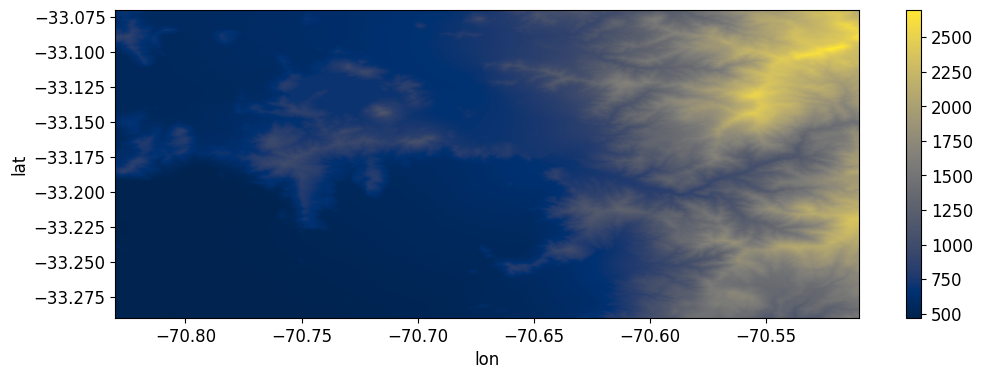

In [187]:
# Este código se encarga de descargar un DEM de Copernicus y mostrarlo como una imagen

Tiles().download_dem(AOI, filename=DEM).plot.imshow(cmap='cividis')

# Ejecutar un Clúster Local de Dask
Inicia un clúster de Dask para realizar cálculos locales y distribuidos utilizando múltiples núcleos. Esto permite procesar conjuntos de datos Sentinel-1 SLC de escala terabyte.

Un Dask es una herramienta para computación paralela que sirve para aprovechar múltiples núcleos de tu computador (local o distribuido). Esto permite manejar y procesar grandes volúmenes de datos, como imágenes de radar Sentinel-1, incluso en computadoras con recursos limitados.

In [188]:
# Inicialización de un Dask, en donde se revisa si ya hay uno en ejecución
if 'client' in globals():
    client.close()
client = Client()
client

INFO:distributed.scheduler:Remove client Client-1829b52f-d2a6-11ef-822f-0242ac1c0002
INFO:distributed.core:Received 'close-stream' from tcp://127.0.0.1:32850; closing.
INFO:distributed.scheduler:Remove client Client-1829b52f-d2a6-11ef-822f-0242ac1c0002
INFO:distributed.scheduler:Close client connection: Client-1829b52f-d2a6-11ef-822f-0242ac1c0002
INFO:distributed.scheduler:Retire worker addresses (0, 1)
INFO:distributed.nanny:Closing Nanny at 'tcp://127.0.0.1:36275'. Reason: nanny-close
INFO:distributed.nanny:Nanny asking worker to close. Reason: nanny-close
INFO:distributed.nanny:Closing Nanny at 'tcp://127.0.0.1:45265'. Reason: nanny-close
INFO:distributed.nanny:Nanny asking worker to close. Reason: nanny-close
INFO:distributed.scheduler:Remove client Client-worker-451d2579-d2a6-11ef-a3da-0242ac1c0002
INFO:distributed.core:Received 'close-stream' from tcp://127.0.0.1:42930; closing.
INFO:distributed.scheduler:Remove client Client-worker-451d2579-d2a6-11ef-a3da-0242ac1c0002
INFO:distr

<Client: 'tcp://127.0.0.1:34371' processes=2 threads=2, memory=12.67 GiB>

# ¿Qué es un SBAS?

SBAS significa "Small Baseline Subset" (Conjunto de Líneas Base Pequeñas). Es una técnica usada en InSAR (Interferometría de Radar de Apertura Sintética) que toma varias imágenes de radar (SAR) de un mismo lugar tomadas en diferentes momentos. Luego, selecciona imágenes que estén cerca en tiempo y que tengan pequeñas diferencias de posición entre las órbitas del satélite, para así, combinar estas imágenes para detectar y medir cambios en la superficie del terreno (como deformaciones, subsidencia o movimientos).

El objetivo de SBAS es generar mapas detallados y precisos de cómo se deforma el terreno con el tiempo.

In [189]:
# Se buscan las escenas Sentinel-1 (SLC) dentro del directorio de datos (DATADIR) que
# coincidan con el sub-swath y la polarización especificada. Esto se guarda en la variable scenes.

scenes = S1.scan_slc(DATADIR, subswath=SUBSWATH, polarization=POLARIZATION)

In [190]:
# Se crea un objeto Stack de PyGMTSAR que representa el conjunto de escenas para el
# procesamiento SBAS.

sbas = Stack(WORKDIR, drop_if_exists=True).set_scenes(scenes)
sbas.to_dataframe()

NOTE: auto set reference scene 2023-05-26. You can change it like Stack.set_reference("2022-01-20")


datetime orbit mission polarization  subswath  \
date                                                                  
2023-05-26 2023-05-26 10:04:34     D     S1A           VV         1   
2024-06-01 2024-06-01 10:04:38     D     S1A           VV         1   
2025-01-03 2025-01-03 10:04:32     D     S1A           VV         1   

                                                                                                       datapath  \
date                                                                                                              
2023-05-26  /content/directorios_slc/data_minalosbronces/S1A_IW_SLC__1SDV_20230526T100433_20230526T100500_04...   
2024-06-01  /content/directorios_slc/data_minalosbronces/S1A_IW_SLC__1SDV_20240601T100437_20240601T100504_05...   
2025-01-03  /content/directorios_slc/data_minalosbronces/S1A_IW_SLC__1SDV_20250103T100432_20250103T100458_05...   

                                                                                                       metapath  \
date                                                                                                              
2023-05-26  /content/directorios_slc/data_minalosbronces/S1A_IW_SLC__1SDV_20230526T100433_20230526T100500_04...   
2024-06-01  /content/directorios_slc/data_minalosbronces/S1A_IW_SLC__1SDV_20240601T100437_20240601T100504_05...   
2025-01-03  /content/directorios_slc/data_minalosbronces/S1A_IW_SLC__1SDV_20250103T100432_20250103T100458_05...   

           noisepath calibpath  \
date                             
2023-05-26      None      None   
2024-06-01      None      None   
2025-01-03      None      None   

                                                                                                      orbitpath  \
date                                                                                                              
2023-05-26  /content/directorios_slc/data_minalosbronces/S1A_OPER_AUX_POEORB_OPOD_20230615T080903_V20230525T...   
2024-06-01  /content/directorios_slc/data_minalosbronces/S1A_OPER_AUX_POEORB_OPOD_20240621T070825_V20240531T...   
2025-01-03  /content/directorios_slc/data_minalosbronces/S1A_OPER_AUX_RESORB_OPOD_20250103T112115_V20250103T...   

                                                                                                       geometry  
date                                                                                                             
2023-05-26  MULTIPOLYGON (((-70.09181 -33.03758, -70.1464 -33.02514, -70.19615 -33.01379, -70.23088 -33.0058...  
2024-06-01  MULTIPOLYGON (((-70.09044 -33.0384, -70.14504 -33.02596, -70.19479 -33.01461, -70.22952 -33.0067...  
2025-01-03  MULTIPOLYGON (((-70.09265 -33.0384, -70.14722 -33.02597, -70.19695 -33.01462, -70.23167 -33.0067...

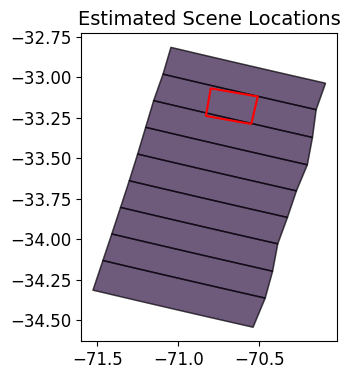

In [191]:
# Genera un gráfico que muestra la ubicación de las escenas Sentinel-1 en un mapa, utilizando el área de
# interés (AOI) como referencia.

sbas.plot_scenes(AOI=AOI)

In [158]:
print(sbas.open_data)

<bound method IO.open_data of Object Stack 10 items
                      datetime orbit mission polarization  subswath  \
date                                                                  
2021-02-06 2021-02-06 09:55:24     D     S1B           VV         1   
2022-02-07 2022-02-07 09:56:20     D     S1A           VV         1   
2022-04-08 2022-04-08 09:56:20     D     S1A           VV         1   
2022-09-23 2022-09-23 09:56:32     D     S1A           VV         1   
2022-10-29 2022-10-29 09:56:33     D     S1A           VV         1   
2022-12-28 2022-12-28 09:56:30     D     S1A           VV         1   
2023-05-26 2023-05-26 10:04:34     D     S1A           VV         1   
2024-06-01 2024-06-01 10:04:38     D     S1A           VV         1   
2024-11-23 2024-11-23 09:56:33     D     S1A           VV         1   
2025-01-03 2025-01-03 10:04:32     D     S1A           VV         1   

                                                                                               

# Reframe Scenes

Se encarga de recortar y unir escenas Sentinel-1 para optimizar el procesamiento InSAR. Es un paso opcional pero recomendable, especialmente cuando se trabaja con áreas de interés (AOI) específicas.

In [192]:
# Esta función realiza el corte y la unión (stitching) de las escenas Sentinel-1.

sbas.compute_reframe(AOI)

Reframing:   0%|          | 0/3 [00:00<?, ?it/s]

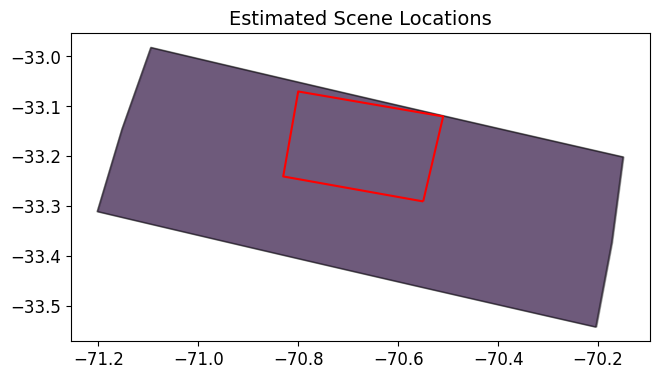

In [193]:
# Genera un gráfico que muestra las escenas recortadas y unidas en un mapa,
# utilizando el AOI como referencia.

sbas.plot_scenes(AOI=AOI)

# Cargar DEM

En el procesamiento InSAR, el Modelo Digital de Elevación (DEM) es fundamental para:

- **Corrección topográfica:** el DEM se utiliza para eliminar la influencia del relieve del terreno en las mediciones de deformación.

- **Geocodificación:** el DEM perite transformar las coordenadas de as imágenes SAR a un sistema de coordenadas geográficas.

In [194]:
# Se utilizará el área de interés (AOI) para acelerar el procesamiento
# al cargar solo la porción del DEM que se necesita.

sbas.load_dem(DEM, AOI)

Save DEM on WGS84 Ellipsoid:   0%|          | 0/9000000.0 [00:00<?, ?it/s]

INFO:distributed.scheduler:Receive client connection: Client-worker-8da4490a-d2a9-11ef-baa5-0242ac1c0002
INFO:distributed.core:Starting established connection to tcp://127.0.0.1:35482


In [195]:
print(sbas.open_data)

<bound method IO.open_data of Object Stack 3 items
                      datetime orbit mission polarization  subswath  \
date                                                                  
2023-05-26 2023-05-26 10:04:37     D     S1A           VV         1   
2024-06-01 2024-06-01 10:04:41     D     S1A           VV         1   
2025-01-03 2025-01-03 10:04:35     D     S1A           VV         1   

                                                                                                       datapath  \
date                                                                                                              
2023-05-26  /content/directorios_slc/raw_minalosbronces/s1a-iw1-slc-vv-20230526t100437-20230526t100443-04870...   
2024-06-01  /content/directorios_slc/raw_minalosbronces/s1a-iw1-slc-vv-20240601t100441-20240601t100446-05412...   
2025-01-03  /content/directorios_slc/raw_minalosbronces/s1a-iw1-slc-vv-20250103t100435-20250103t100441-05727...   

                 

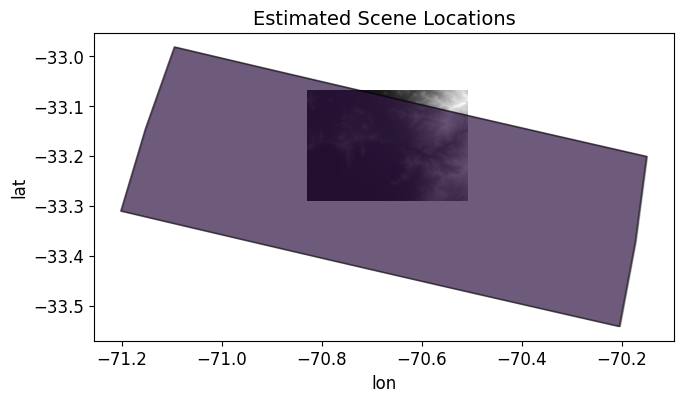

In [196]:
# Este código se encarga de generar un gráfico que muestra la ubicación de las escenas
# Sentinel-1 y luego guardar ese gráfico como una imagen JPG

sbas.plot_scenes()
plt.savefig('Estimated Scene Locations.jpg')

## Align Images

Esta sección se encarga de alinear las imágenes Sentinel-1 para que estén correctamente superpuestas antes de generar los interferogramas. La alineación precisa es crucial para obtener resultados InSAR de calidad.

In [197]:
# Se utiliza la función copute_align() del objeto sbas (que representa el conjunto de escenas
# para el procesamiento InSAR) para realizar la alineación de las imágenes.
# PyGMTSAR utiliza algoritmos de correlación cruzada para encontrar el desplazamiento entre las
# imágenes y alinearlas con precisión.

sbas.compute_align()

Preparing Reference:   0%|          | 0/1 [00:00<?, ?it/s]

Aligning Repeat:   0%|          | 0/2 [00:00<?, ?it/s]

# Geocoding Transform

Este sección se encarga de geocodificar las imágenes Sentinel-1, es decir, transformar las coordenadas de las imágenes desde el sistema de coordenadas del sensor (radar) a un sistema de coordenadas geográficas (latitud y longitud). Este proceso es fundamental para poder visualizar y analizar los resultados InSAR en un contexto geográfico real.




In [198]:
# Se utiliza la configuración predeterminada de PyGMTSAR para la geocodificación,
# que genera una malla de coordenadas geográficas con una resolución de 60 metros.

sbas.compute_geocode()

# PyGMTSAR utiliza la información del DEM y las órbitas de los satélites
# para realizar la transformación de coordenadas. El resultado de la geocodificación es un conjunto
# de imágenes que están georreferenciadas, es decir, que cada pixel de la imagen tiene una ubicación
# geográfica definida.

Radar Transform Computing:   0%|          | 0/1 [00:00<?, ?it/s]

Radar Transform Saving:   0%|          | 0/9000000.0 [00:00<?, ?it/s]

Radar Transform Indexing:   0%|          | 0/9000000.0 [00:00<?, ?it/s]

Radar Inverse Transform Computing:   0%|          | 0/9000000.0 [00:00<?, ?it/s]

INFO:distributed.scheduler:Receive client connection: Client-worker-17dbec4a-d2aa-11ef-baa8-0242ac1c0002
INFO:distributed.core:Starting established connection to tcp://127.0.0.1:42396


Satellite Look Vector Computing:   0%|          | 0/9000000.0 [00:00<?, ?it/s]

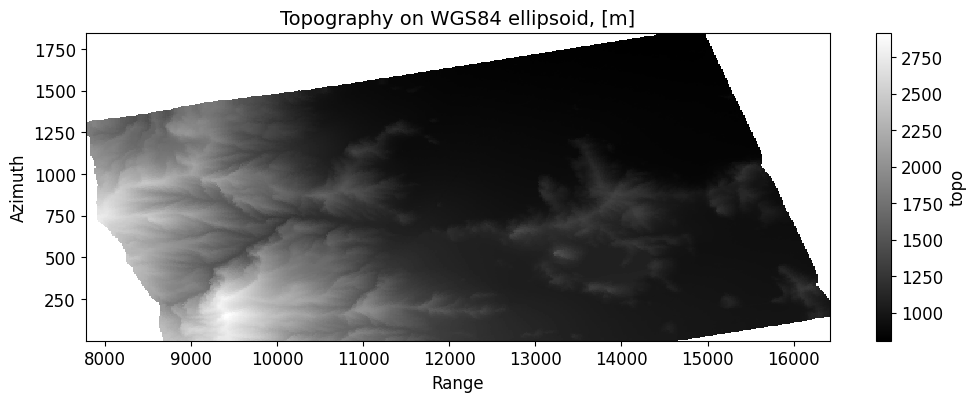

In [199]:
# Este código se encarga de generar un gráfico de la topografía utilizando el DEM
# cargado previamente y luego guardar ese gráfico como una imagen JPG.

sbas.plot_topo()

plt.savefig('Topography on WGS84 ellipsoid, [m].jpg')

# Interferograma

Es una imagen que muestra la diferencia de fase entre dos imágenes SAR adquiridas en momentos diferentes. Esta diferencia de fase puede ser causada por varios factores, como la deformación del terreno, los cambios en la humedad del suelo o la vegetación, o la presencia de objetos en movimiento.

Esta sección del código se encarga de generar un interferograma a partir de las imágenes Sentinel-1 alineadas y geocodificadas previamente. El código realiza varios pasos de preprocesamiento y filtrado para mejorar la calidad del interferograma.

In [202]:
# Se define la lista pairs que contiene los índices de las escenas que se utilizarán
# para generar el interferograma. En este caso, se utiliza un solo par de escenas.

pairs = [[sbas.to_dataframe().index[0], sbas.to_dataframe().index[-1]]]
pairs

[['2023-05-26', '2025-01-03']]

In [203]:
# Se carga la topografía del radar (topo) y los datos de las escenas
# sentinel-1 (data). Acá se carga el modelo de topografía del área de estudio, que es crucial
# para corregir efectos relacionados con la elevación del terreno en el análisis interferométrico

topo = sbas.get_topo()
data = sbas.open_data()

#LEER TEXTO
intensity15m = sbas.multilooking(np.square(np.abs(data)), wavelength=200, coarsen=(1,4))

# Calcula la diferencia de fase entre las imágenes SAR de cada par en pairs. En donde topo, usa
# los datos de topografía para corregir los efectos del terreno.

phase = sbas.phasediff(pairs, data, topo)

# Similar al paso anterior de intensidad, pero ahora aplicado a los datos de fase.
phase15m = sbas.multilooking(phase, wavelength=200, coarsen=(1,4))

# Se calcula la correlación entre los datos de fase y la intensidad. La correlación mide la coherencia
# entre las imágenes SAR, lo que indica qué tan confiables son los datos en cada pixel.
corr15m = sbas.correlation(phase15m, intensity15m)

# Aplica un filtro Goldstein, que es un método avanzado para reducir el ruido en los datos de fase.
phase15m_goldstein = sbas.goldstein(phase15m, corr15m, 32)

intf15m = sbas.interferogram(phase15m_goldstein)

decimator = sbas.decimator()

tqdm_dask(result := dask.persist(decimator(corr15m), decimator(intf15m)), desc='Compute Phase and Correlation')

corr60m, intf60m = [grid[0] for grid in result]

Compute Phase and Correlation:   0%|          | 0/9000000.0 [00:00<?, ?it/s]

# Filtrado gaussiano de la intensidad SAR

Un filtro gaussiano es una técina que suaviza los datos, eliminando detalles pequeños o ruido, para resaltar técnicas más generales. Este tipo de filtro se basa en una función matemática llamada distribución gaussiana, que da más peso a los valores cercanos al centro del área analizada.

En el contexto de imágenes o datos espaciales, el filtro gaussiano:

- Elimina ruido de alta frecuencia (pequeñas variaciones no deseadas).
- Mantiene estructuras más grandes y significativas, como patrones amplios en la intensidad o fase del radar.

## Código en detalle

1. np.abs(data): obtiene la intensidad de los datos de radar al calcular el valor absoluto de los valores complejos en data. Recordando que la intensidad representa la potencia de la señal que el radar detecta al reflejarse en el terreno.

2. np.square(...):eleva al cuadrado la intensidad para amplificar las diferencias entre áreas de alta y baja señal.

3. sbas.multilooking(...): acá se aplican dos cosas:
- Filtrado gaussiano con wavelength=200: este parámetro indica que los detalles más pequeños que 200 metros se suavizan o eliminan. Este filtro resalta estructuras o patrones espaciales que son más grandes que 200 metros.
- coarsen=(1,4): reduce la resolución espacial en la dirección de rango (perpendicular al movimiento del satélite). Por cada 4 pixeles en rango, se toma un valor promedio, lo que mejora la relación señal-ruido.

De esto se obtiene como resultado una versión suavizada de la intesidad SAR con menos ruido y una resolución espacial reducida (15 m en azimut y 60 m en rango después del multilooking).





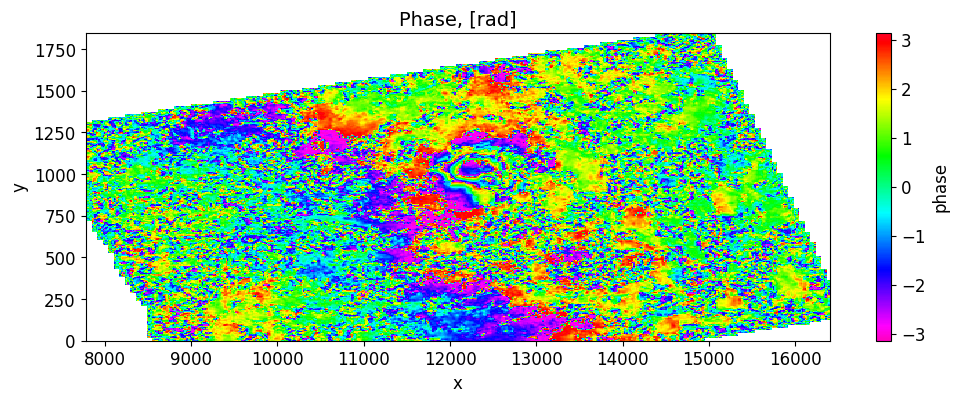

In [204]:
# Llama a un método de la biblioteca sbas para generar un interferograma

sbas.plot_interferogram(intf60m)
plt.savefig('Phase, [rad].jpg')

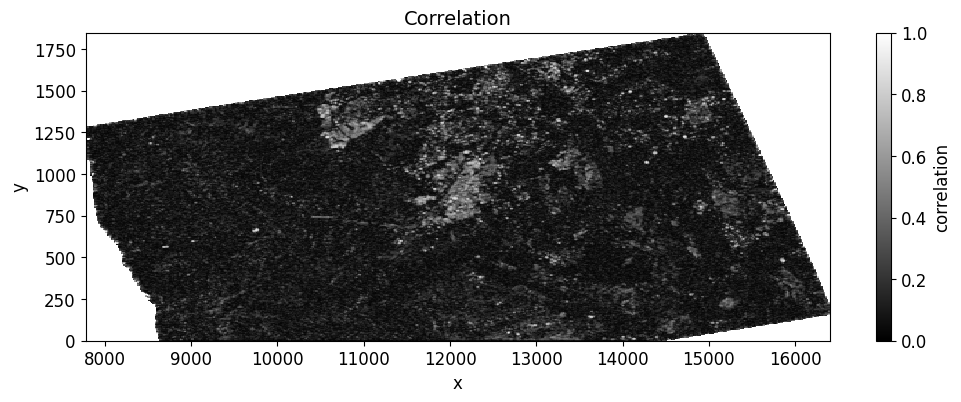

In [205]:
# Grafica la correlación de los datos SAR a una resolución de 60 metros.
# corr60m es el resultado del cálculo de la correlación de coherencia en los datos
# interferométricos.

sbas.plot_correlation(corr60m)
plt.savefig('Correlation.jpg')

# ¿Qué es la correlación de coherencia?
La correlación de coherencia es una medida de la calidad del interferograma. Indica qué tan bien se correlacionan las señales de radar entre dos imágenes SAR.

Sus valores van de 0 a 1:

- Cercano a 1: Alta coherencia, lo que significa que las señales están bien alineadas. Ocurre en áreas como: Suelo desnudo, Estructuras artificiales (edificios, carreteras), Terrenos estables sin vegetación.
- Cercano a 0: Baja coherencia, lo que indica señales desalineadas. Puede deberse a: Zonas con vegetación densa, Cambios rápidos en el terreno entre las dos adquisiciones SAR, Agua (que refleja señales inconsistentes).


# ¿Qué esperar al graficarlo?
Un mapa de colores que muestra la correlación en el área de interés:
- **Colores claros (blanco o amarillo):** Alta coherencia.
- **Colores oscuros (negro o azul):** Baja coherencia.

Este mapa ayuda a identificar áreas donde los datos interferométricos son más confiables y útiles.

In [206]:
sbas.export_vtk(intf60m[::3,::3], 'intf')

Exporting WGS84 VTK(s):   0%|          | 0/1 [00:00<?, ?it/s]

In [207]:
# Gráfica interactiva 3D
plotter = pv.Plotter(notebook=True)
plotter.add_mesh(pv.read('intf.vtk').scale([1, 1, 0.00002], inplace=True), scalars='phase', cmap='turbo', ambient=0.1, show_scalar_bar=True)
plotter.show_axes()
plotter.show(screenshot='3D Interferogram.png', jupyter_backend='panel', return_viewer=True)
plotter.add_title(f'Interactive Interferogram on DEM', font_size=32)
plotter._on_first_render_request()
panel.panel(
    plotter.render_window, orientation_widget=plotter.renderer.axes_enabled,
    enable_keybindings=False, sizing_mode='stretch_width', min_height=600
)

INFO:distributed.core:Event loop was unresponsive in Nanny for 4.83s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
INFO:distributed.core:Event loop was unresponsive in Nanny for 4.84s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
INFO:distributed.core:Event loop was unresponsive in Scheduler for 5.06s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.


VTKRenderWindowSynchronized(vtkXOpenGLRenderWindow, color_mappers=[LinearColorMapper(id='bda...], min_height=600, orientation_widget=True, sizing_mode='stretch_width')

# Desenvolvimiento (Unwrapping)
El proceso de desenvolvimiento requiere mucha memoria RAM, especialmente cuando se ejecutan muchos procesos paralelos al mismo tiempo. Para limitar las tareas de procesamiento paralelo, se puede usar el argumento "n_jobs". El valor por defecto, n_jobs=-1, utiliza todos los núcleos del procesador. Además, se recomienda reducir el tamaño de los interferogramas mediante decimación para disminuir la carga de memoria. También se puede usar una configuración personalizada de SNAPHU para optimizar el uso de RAM.

In [208]:
# mask low-coherence areas using threshold value 0.1
tqdm_dask(unwrap := sbas.unwrap_snaphu(intf60m, corr60m.where(corr60m>=0.1)).persist(), desc='SNAPHU Unwrapping')

SNAPHU Unwrapping:   0%|          | 0/9000000.0 [00:00<?, ?it/s]

In [209]:
# geocode to geographic coordinates and crop empty borders
unwrap_ll = sbas.cropna(sbas.ra2ll(unwrap.phase))

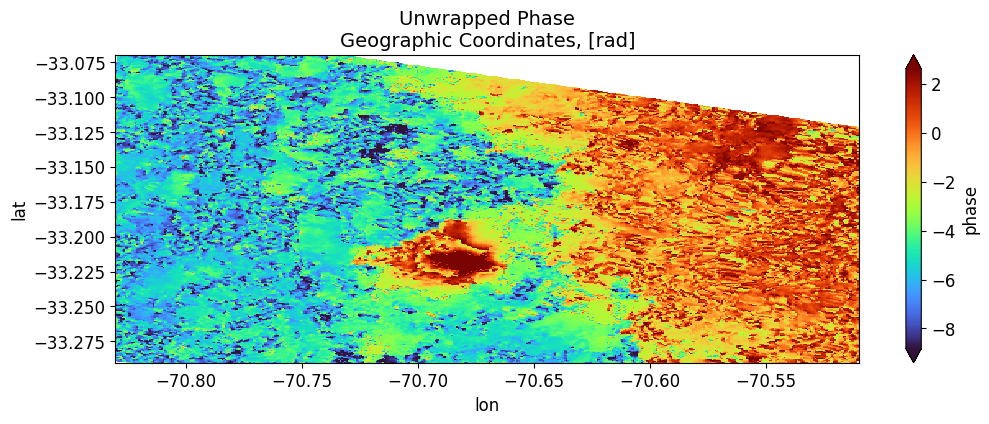

In [210]:
sbas.plot_phase(unwrap_ll, caption='Unwrapped Phase\nGeographic Coordinates, [rad]', quantile=[0.01, 0.99])

# Desplazamiento LOS

In [211]:
# geocode to geographic coordinates and crop empty borders
los_disp_mm_ll = sbas.cropna(sbas.ra2ll(sbas.los_displacement_mm(unwrap.phase)))

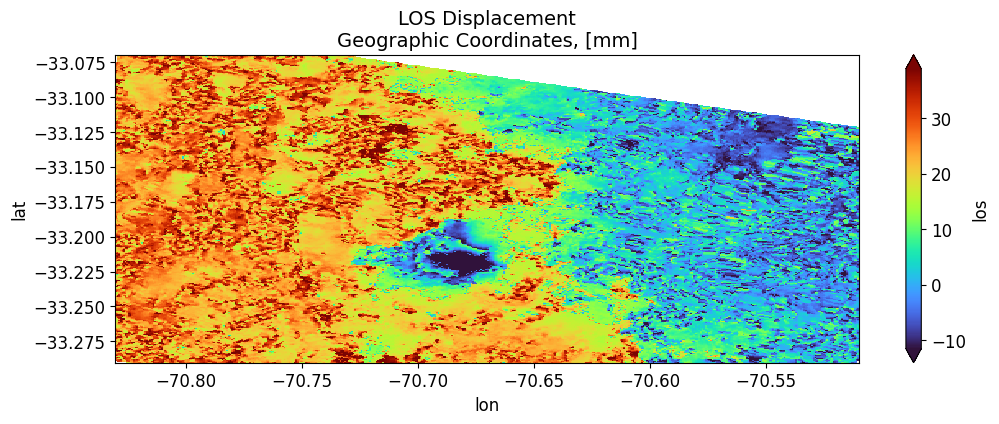

In [212]:
sbas.plot_displacement(los_disp_mm_ll, caption='LOS Displacement\nGeographic Coordinates, [mm]', quantile=[0.01, 0.99])
plt.savefig('LOS Displacement Geographic Coordinates, [mm].jpg')

In [213]:
sbas.export_vtk(los_disp_mm_ll[::3,::3], 'los')

Exporting WGS84 VTK(s):   0%|          | 0/1 [00:00<?, ?it/s]

In [214]:
# build interactive 3D plot
plotter = pv.Plotter(notebook=True)
plotter.add_mesh(pv.read('los.vtk').scale([1, 1, 0.00002], inplace=True), scalars='los', cmap='turbo', ambient=0.1, show_scalar_bar=True)
plotter.show_axes()
plotter.show(screenshot='3D LOS Displacement.png', jupyter_backend='panel', return_viewer=True)
plotter.add_title(f'Interactive LOS Displacement on DEM', font_size=32)
plotter._on_first_render_request()
panel.panel(
    plotter.render_window, orientation_widget=plotter.renderer.axes_enabled,
    enable_keybindings=False, sizing_mode='stretch_width', min_height=600
)

VTKRenderWindowSynchronized(vtkXOpenGLRenderWindow, color_mappers=[LinearColorMapper(id='600...], min_height=600, orientation_widget=True, sizing_mode='stretch_width')

# Medición del desplazamiento m+inimo y máximo en LOS, [mm]

In [215]:
np.array(los_disp_mm_ll.min().round()), np.array(los_disp_mm_ll.max().round())

(array(-41., dtype=float32), array(56., dtype=float32))

# Guardemos los resultados


In [216]:
# save the results
corr60m.to_netcdf('los_disp_mm_ll.nc', engine=sbas.netcdf_engine)

In [217]:
# Exportando de Google Colab
if 'google.colab' in sys.modules:
    from google.colab import files
    files.download('los_disp_mm_ll.nc')
    files.download('intf.vtk')
    files.download('los.vtk')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>